## Imports 

In [1]:
import sys
import numpy as np
import pandas as pd
import random
import math
import pickle
import os
import pathlib
from tqdm import tqdm

## for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## for ML 
from skimage.measure import label, regionprops, regionprops_table

## for DL
from GPUtil import showUtilization as gpu_usage
import torch
from torch.utils.data import Dataset, DataLoader
import time
import torch
import torchvision
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import Dropout
# from torchsummary import summary
from torchinfo import summary

from torch.nn import BatchNorm2d 

from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn.functional import normalize

In [2]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
# print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(gpu_usage())

__Python VERSION: 3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]
__pyTorch VERSION: 2.2.1+cu121
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8902
__Number CUDA Devices: 8
Available devices  8
Current cuda device  0
| ID | GPU | MEM |
------------------
|  0 |  0% | 66% |
|  1 | 81% | 77% |
|  2 | 83% | 64% |
|  3 | 88% | 64% |
|  4 | 82% | 64% |
|  5 | 79% | 64% |
|  6 | 83% | 64% |
|  7 | 71% | 64% |
None


## Dataset creatioin 
### Extraction --> filtering --> property  --> class creation 
- medical image cn https://learnopencv.com/medical-multi-label/
- response map on image https://learnopencv.com/fully-convolutional-image-classification-on-arbitrary-sized-image/
- https://glassboxmedicine.com/2022/01/21/building-custom-image-data-sets-in-pytorch-tutorial-with-code/
- https://stackoverflow.com/questions/62434037/python-class-dataset-how-to-concatenate-images-with-their-respective-labels-in
- imbalance in dataset https://neptune.ai/blog/how-to-deal-with-imbalanced-classification-and-regression-data

In [6]:
def plotSanityCheckImages(imgList, name):
    """create a functin to check the cropped images"""
    figure, axs = plt.subplots(nrows=3, ncols=5, figsize=(10,5), sharex = False, sharey = False)
    # print(len(imgList))
    for i, ax in enumerate(axs.flatten()):
        index = random.randrange(len(imgList))
        image = imgList[index]
        ax.imshow(image)
        ax.grid(False)
        
    figure.suptitle(f"Total '{len(imgList)}' unique images in {name} SET", fontsize = 10)
    plt.tight_layout()
    plt.show()
    return None


def dataTransform(image, mask, property, label, _num_augmentation):
    images_list, masks_list = [], []
    
    transform = A.Compose([ A.HorizontalFlip(p = 0.51),
                            A.VerticalFlip(p = 0.51),
                            A.Rotate(p = 0.51),
                              ])

    # for i in range(_num_augmentation):
    #     augmentations = transform(image = np.array(image), mask = np.array(mask))
    #     images_list.append(augmentations["image"])
    #     masks_list.append(augmentations["mask"])
    #     # plt.imshow(augmentations["image"])
    #     # plt.show()
    augmentations = transform(image = np.array(image), mask = np.array(mask))
    images_list = augmentations["image"]
    masks_list = augmentations["mask"]
        
    # print(f"images_list after dataTransform: {len(images_list)}, {label}\n" )
   
        
    return images_list, masks_list, property, label
    

In [3]:
def yPropCreate(feature_dic, _prop):
    """"Adds a target to the csv based on the input provided for a particular metric development
        returns: 
        _prop -> (underlying property), 
        prop -> (new processed property), 
        label -> (binary coding for each property)
    """
    _prop = _prop.lower()

    if _prop == 'density':
        prop = ['LightEB', 'DenseEB']
        prop = 'LightEB' if (prop == ['LightEB']) else 'DenseEB'
        _label = 1 if (prop == 'LightEB') else 0

    elif _prop == 'outline':
        prop = ['SmoothOutline', 'RoughOutline', 'VeryRoughOutline']
        prop = list(set(feature_dic) & set(prop))
        prop = 'RoughOutline' if (prop == ['RoughOutline'] or prop == ['VeryRoughOutline']) else 'SmoothOutline'
        _label = 1 if (prop == 'RoughOutline') else 0

    elif _prop == 'cysticity':
        prop = ['NonCytstic', 'Cytstic', 'HeavilyCystic']
        prop = list(set(feature_dic) & set(prop))
        prop = 'Cystic' if (prop == ['HeavilyCystic'] or prop == ['Cytstic']) else 'NonCystic'
        _label = 1 if (prop == 'Cystic') else 0

    elif _prop == 'shape':
        prop = ['IrregularShaped', 'RoundShaped', 'OvalShaped']
        prop = list( set(feature_dic) & set(prop))
        prop = 'RoundShaped' if (prop == ['OvalShaped'] or prop == ['RoundShaped']) else 'IrregularShaped'
        _label = 1 if (prop == 'RoundShaped') else 0
    
    else: return print("wrong input, add either 'density','outline','cysticity', 'shape'")
    # print(_prop, prop)
    return _prop, prop, _label

def readData(imagePath, combinedCsvPath, filterCols, featureCols, dev = False, _prop = None):
    """Reads and creates a list of EB wit corresponding feature tags"""
    images, masks = [], []
    property, label = [], []
    comb_df = pd.read_csv(combinedCsvPath)

    for dirname, _, filenames in os.walk(imagePath):
        ## get the spheroid images
        for filename in filenames:
            if filename == '.DS_Store' or pathlib.Path(filename).suffix == '.pickle':
                continue
            else:
                path = os.path.join(dirname, filename)
                with open(path, 'rb') as f:
                    data = pickle.load(f)
                    # mask, oriImage, markedImage = data[0], data[1], data[3]
                    spheroidInfoDic = data[2]
                    # stats(area,x,y,h,w,centroids[i]),cropped_oriImage,cropped_segMask,componentMask,cropped_segImage=spheroidInfoDic[spheroidName][0], .. [4]
                     
                for index, spheroidName in enumerate(spheroidInfoDic):
                    cropped_segMask = spheroidInfoDic[spheroidName][2]
                    cropped_segImage = spheroidInfoDic[spheroidName][4]          
                    x = comb_df[comb_df['example'] == spheroidName]
                    filterTags = list(x[filterCols].values.flat)
                    featureTags = list(x[featureCols].values.flat)

                    if ('Edge' in filterTags) or ('CannotDetermine' in filterTags):
                        continue
                    elif ('Center' in filterTags) and ('CanDetermine' in filterTags) : 
                        # print(f'\nselected---{filterTags}---{spheroidName}')
                        images.append(cropped_segImage)
                        mask = np.where(np.array(cropped_segMask) >= 1, 1.0, 0.0)
                        masks.append(mask)
                        ## add fature tags
                        propName, prop, _label = yPropCreate(featureTags, _prop)
                        property.append(prop)
                        label.append(_label)
                if dev == True: break


    return images, masks, property, label



In [4]:
class ebDataset(Dataset):
    def __init__ (self, imagePath, combinedCsvPath, filterCols, featureCols, 
                  dev = None, prop = None, transform = None, num_augmentations = None):
        self.imagePath = imagePath
        self.combinedCsvPath = combinedCsvPath
        self.filterCols = filterCols
        self.featureCols = featureCols
        self.prop = prop
        self.dev = dev
        self.transform = transform
        self.num_augmentations = num_augmentations
        self.croppedImageList = {}
        # self.dataLength = self.create_idx_mapping()

        self.images, self.mask, self.property, self.label = readData(self.imagePath, self.combinedCsvPath, 
                                                                     self.filterCols, self.featureCols, self.dev, self.prop)
        
    def __len__(self):
        if self.transform == True:
            length = len(self.images) * self.num_augmentations
        else:
            length = len(self.images)
        return length
    
    def __getitem__(self, idx):

        if self.transform == True:
            _length = len(self.images) * self.num_augmentations
            original_idx = idx // self.num_augmentations
            _ebimages = self.images[original_idx]
            _mask = self.mask[original_idx]
            _property = self.property[original_idx]
            _label = self.label[original_idx]
            _ebImages, _mask, _property, _label = dataTransform(image = _ebimages, mask = _mask, property = _property, 
                                                                label = _label, _num_augmentation = self.num_augmentations)
            # print(idx)
            augmentation_idx = idx % _length #self.num_augmentations
            # _ebImages = self.images[augmentation_idx]
            # _mask = self.mask[augmentation_idx]
            # _property = self.property[augmentation_idx] 
            # _label = self.label[augmentation_idx]
            # plt.imshow(_ebImages)
            # plt.imshow(_ebImages[0])
            # plt.title(f'transformed1_label:{_label}, randomIndex:{idx}, augmentation_idx:{augmentation_idx}, original_idx:{original_idx}', fontsize = 10)
            # plt.show()
            
        else:
            original_idx = idx
            _ebImages = self.images[original_idx]
            _mask = self.mask[original_idx]
            _property = self.property[original_idx]
            _label = self.label[original_idx]
            print(f"_ebImages: {_ebImages.shape}, _label{_label}")
            plt.imshow(_ebImages)
            plt.title(f'_label:{_label},original_idx:{original_idx}', fontsize = 10)
            # print('not transformed')
        
        # Retrieve image, mask and propert from pre-loaded readData
        # _ebImages = self.images[original_idx]
        # _mask = self.mask[original_idx]
        # _property = self.property[original_idx]

        # # transform -> new imdex
        # if self.transform == True:
        #     _images, _mask, _property = dataTransform(image = _images, mask = _mask, property = _property) 
        #     _ebImages = self.images[augmentation_idx]
        #     _mask = self.mask[augmentation_idx]
        #     _property = self.property[augmentation_idx]          
        # else:
        #     _ebImages = self.images[original_idx]
        #     _mask = self.mask[original_idx]
        #     _property = self.property[original_idx]

        return _ebImages, _mask, _property, _label


## checking the classes

Total images after augmentation -  3632


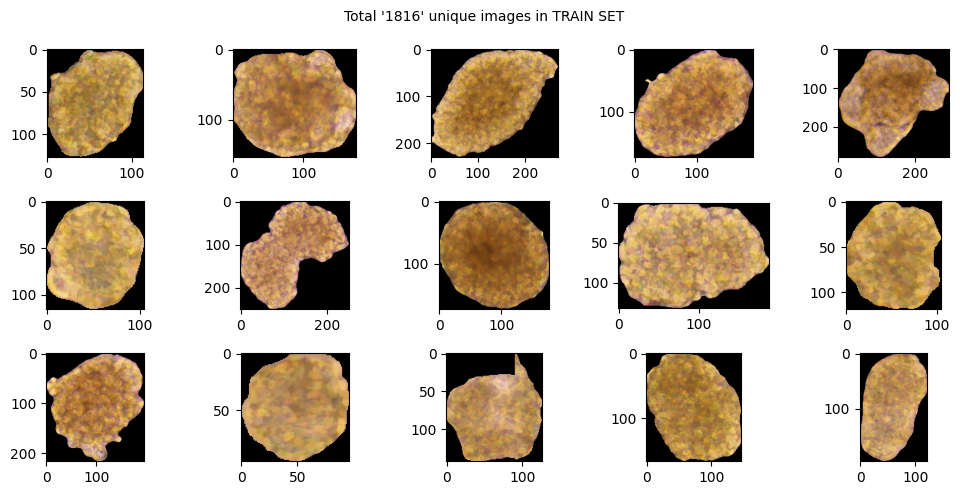

In [7]:
trainSet_imgPath = '/user/s.chakrabarty/myoTwinWork/data/spheroidDetails'  
combinedCsvPath = "/user/s.chakrabarty/myoTwinWork/data/annotated_spheroids/combined_csvPath/combinedAnnotated.csv"
filterCols = ['Location_tags', 'Determine_tags']
featureCols = ['Overlapping_tags', 'Connected_tags','Density_tags', 'Outline_tags','Cystic_tags', 'Shape_tags']
prop = 'cysticity' #'density','outline','cysticity', 'shape'
NUM_AUGMENTATION = 2
_transform = True #False # True        

TrainDataset = ebDataset(trainSet_imgPath, combinedCsvPath, filterCols, featureCols, dev = False,
                         prop = prop, transform = _transform, num_augmentations = NUM_AUGMENTATION)
if _transform == True: print('Total images after augmentation - ', len(TrainDataset))
plotSanityCheckImages(TrainDataset.images, 'TRAIN')

In [ ]:
testSet_imgPath = '/user/s.chakrabarty/myoTwinWork/data/testSpheroidDetails'
combinedCsvPath = "/user/s.chakrabarty/myoTwinWork/data/annotated_spheroids/combined_csvPath/combinedAnnotated.csv"
filterCols = ['Location_tags', 'Determine_tags']
featureCols = ['Overlapping_tags', 'Connected_tags','Density_tags', 'Outline_tags','Cystic_tags', 'Shape_tags']
prop = 'cysticity' #'density','outline','cysticity', 'shape'
# test_images, test_masks, test_property, test_label = readData(testSet_imgPath, combinedCsvPath, filterCols, featureCols, _prop = prop)
# print(len(test_images), test_label)

TestDataset = ebDataset(testSet_imgPath, combinedCsvPath, filterCols, featureCols, 
                        prop = prop, transform = None, num_augmentations = 0)

plotSanityCheckImages(TestDataset.images, 'TEST')


## dataLoader creation 

- collate func for paddig https://stackoverflow.com/questions/55041080/how-does-pytorch-dataloader-handle-variable-size-data 
    -- https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/15 -- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3 -- https://stackoverflow.com/questions/55041080/how-does-pytorch-dataloader-handle-variable-size-data
- padding to the same dimenions https://stackoverflow.com/questions/61943896/pad-torch-tensors-of-different-sizes-to-be-equal 
- torch stacking https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8

In [ ]:
def max_HeightWidth(batch):
    # _height , _width = [], []
    # for item in batch:
    #     _height.append(item[0].shape[0])
    _height = max((item[0].shape[0]) for item in batch)
    _width = max((item[0].shape[1]) for item in batch)

    return _height, _width #max(_height), max(_width)

def img_padding(batch, max_height, max_width):
    _image_batch, _mask_batch = [], []
    for item in batch:
        img, mask, tag, label = item
        # print(img.shape, mask.shape)
        img_padding = (0, 0, 0, max_width - img.shape[1], 0 ,max_height - img.shape[0])
        mask_padding = (0, max_width - mask.shape[1], 0 ,max_height - mask.shape[0])
        padded_img = F.pad(torch.from_numpy(img), img_padding).permute(2,0,1) # shuffing the dim order to [HWC -> CHW]
        padded_mask = F.pad(torch.from_numpy(mask), mask_padding)
        
        _image_batch.append(padded_img)
        # _image_batch.append(padded_img[0])
        _mask_batch.append(padded_mask)

    return _image_batch, _mask_batch

def custom_collate(batch, _RGB = None):
    import torch.nn.functional as F

    max_height, max_width = max_HeightWidth(batch)
    image_batch, mask_batch = img_padding(batch, max_height, max_width)

    images = torch.stack([item for item in image_batch], dim = 0)
    mask = torch.stack([item for item in mask_batch])  # each element is of size (1, h*, w*). where (h*, w*) changes from mask to another.
    tags = [item[2] for item in batch]
    label = torch.LongTensor([item[3] for item in batch])

    return images, mask, tags, label

# https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
from torchvision.utils import make_grid

def show_batch(data_loader, batch, _showMore = None):
    """Plot images grid of single batch"""
    for i, item in enumerate(data_loader):
        images = item[0]
        mask = item[1]
        tags = item[2]
        label = item[3]
        fig,ax = plt.subplots(figsize = (20, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = batch).permute(1,2,0)) # b is from batch size above cell
        # plt.title([tags, label])
        _title = f'{[tags]} \n {[label]}' 
        plt.title(_title)
        plt.tight_layout
        if (i == 5) and (_showMore == False) :
            break 

In [ ]:
validation_split = 0.3
b = 10
# RGB = True
train_set, validation_set = torch.utils.data.random_split(TrainDataset, [round(len(TrainDataset)*(1-validation_split)),
                                                                         round(len(TrainDataset)*validation_split)])                                       
trainLoader = DataLoader(dataset = train_set, batch_size = b, 
                         collate_fn = custom_collate, num_workers = 4, shuffle = True)
validationLoader = DataLoader(dataset = validation_set, batch_size = b, 
                              collate_fn = custom_collate, num_workers = 4, shuffle = True) 

print(f"Total {len(train_set)} items in the training set")
print(f"Total {len(validation_set)} items in the validation set")
print(f"Total number of train Loaders: {len(trainLoader)},and validation loader {len(validationLoader)}")

for i, (image, mask, tags, label) in enumerate(trainLoader):
    print(image.size())
    print(mask.size())
    print(label)
    print(tags)
    if i == 2: break 

show_batch(trainLoader, batch = b,_showMore = True)

## debug for augmentation 

In [ ]:
trainSet_imgPath = '/user/s.chakrabarty/myoTwinWork/data/spheroidDetails/bigImg_spheroidDetails_1copy'  
combinedCsvPath = "/user/s.chakrabarty/myoTwinWork/data/annotated_spheroids/combined_csvPath/combinedAnnotated.csv"
filterCols = ['Location_tags', 'Determine_tags']
featureCols = ['Overlapping_tags', 'Connected_tags','Density_tags', 'Outline_tags','Cystic_tags', 'Shape_tags']
prop = 'cysticity' #'density','outline','cysticity', 'shape'
NUM_AUGMENTATION = 4
_transform = True #False #True #False #True #False # True        

checkDataset = ebDataset(trainSet_imgPath, combinedCsvPath, filterCols, featureCols, dev = False,
                         prop = prop, transform = _transform, num_augmentations = NUM_AUGMENTATION)
if _transform == True: print('Total images after augmentation - ', len(checkDataset))
else: print('Total images w/o augmentation - ', len(checkDataset))
plotSanityCheckImages(checkDataset.images, 'checkDataset')

random_sampler = torch.utils.data.RandomSampler(checkDataset, num_samples = 120)
# dataloader = torch.utils.data.DataLoader(checkDataset, batch_size=10, sampler=random_sampler)
dataloader = DataLoader(dataset = checkDataset, batch_size = 10, sampler=random_sampler,
                         collate_fn = custom_collate, num_workers = 4)

print(f"Total {len(checkDataset)} items in the checkDataset set, and {len(dataloader)} total dataLoaders")

show_batch(dataloader, batch = 10, _showMore = True)

## creating the model 
- cnn: https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
- differentSize: https://learnopencv.com/fully-convolutional-image-classification-on-arbitrary-sized-image/
- spp implementatiojn: https://github.com/revidee/pytorch-pyramid-pooling ;;;; https://github.com/yifanjiang19/sppnet-pytorch/tree/master

- https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
- cnn for different images https://stackoverflow.com/questions/72595995/how-to-train-network-on-images-of-different-sizes-pytorch
- spp https://github.com/yifanjiang19/sppnet-pytorch/tree/270529337baa5211538bf553bda222b9140838b3?tab=readme-ov-file
- science cnn complete https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895
- different size avgAdavtipve pooling https://stackoverflow.com/questions/72601248/pytorch-cnn-different-input-size
- activation function : https://www.v7labs.com/blog/neural-networks-activation-functions  ;;;;  https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/ ;;;; https://machinelearningmastery.com/introduction-to-softmax-classifier-in-pytorch/ ;;; https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c


### simple CNN

In [ ]:
# https://discuss.pytorch.org/t/pass-varied-sized-images-as-input-to-a-model-without-resizing/123203
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.Conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (7, 7))
        self.Conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5, 5))
        self.Decv1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = (4, 4)) 
        #https://www.geeksforgeeks.org/apply-a-2d-transposed-convolution-operation-in-pytorch/
        self.Sigm1 = nn.Sigmoid()

    def forward(self, X):
        out = self.Conv1(X)
        out = self.Conv2(out)
        out = self.Decv1(out)
        out = self.Sigm1(out)
        return out

model = Net()
MyX = next(iter(trainLoader))
MyOutImg = model(MyX)
print("Original shape of 1st image:", MyX[0].shape, "Output's 1st image shape: ", MyOutImg[0].shape)

# self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

In [ ]:
# https://github.com/yifanjiang19/sppnet-pytorch/blob/master/spp_layer.py
import math
# class spp(Module)
def spatial_pyramid_pool(previous_conv, num_sample, previous_conv_size, out_pool_size):
    '''
    previous_conv: a tensor vector of previous convolution layer
    num_sample: an int number of image in the batch
    previous_conv_size: an int vector [height, width] of the matrix features size of previous convolution layer
    out_pool_size: a int vector of expected output size of max pooling layer
    
    returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''    
    # print(previous_conv.size())
    for i in range(len(out_pool_size)):
        # print(previous_conv_size)
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_pad = int((h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        w_pad = int((w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)
        maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(h_pad, w_pad))
        x = maxpool(previous_conv)
        if(i == 0):
            spp = x.view(num_sample,-1)
            print("spp size:",spp.size())
        else:
            print("size:",spp.size())
            spp = torch.cat((spp,x.view(num_sample,-1)), 1)
    return spp

In [ ]:


# Creating a CNN class https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes = 3):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((32,32))
        # different size avgAdavtipve pooling https://stackoverflow.com/questions/72601248/pytorch-cnn-different-input-size
        
        self.fc1 = nn.Linear(1600, 128) # to get the inupt layer informaton 
        # shape cakculayte https://stackoverflow.com/questions/58811641/calculate-the-shape-in-fully-connected-layer-after-cnn
        # https://discuss.pytorch.org/t/transition-from-conv2d-to-linear-layer-equations/93850/3
        # lazy automatoic https://stackoverflow.com/questions/69876305/pytorch-automatically-determine-the-input-shape-of-linear-layer-after-conv1d

        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        print('initial tensor', x.size())
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        print('1st', out.size())
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        out = self.avgpool(out)
        print('2nd', out.size())
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        print('3rd', out.size())
        return out
    
model = ConvNeuralNet(3)
print(summary(ConvNeuralNet(), input_size=(3, 32, 32), device="cpu")) #ideal input based on reference 
print('----------')
for i, item in enumerate(trainLoader):
    x = item[0]/255 #item[0].float() #mask = item[1] #tags = item[2] #y = item[3]
    print(x[0][0].max())
    model(x)


### SPP with simple CNN 

- https://www.kaggle.com/code/bonhart/pytorch-cnn-from-scratch
- https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

In [ ]:


# Create a neural net class https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch
def spatial_pyramid_pool(previous_conv, out_pool_size, mode):
    '''
    previous_conv: a tensor vector of previous convolution layer
    out_pool_size: a int vector of expected output size of max pooling layer
    
    returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''    
    num_sample = previous_conv.size(0)
    previous_conv_size = [int(previous_conv.size(2)), int(previous_conv.size(3))]
    for i in range(len(out_pool_size)):
        print(previous_conv_size, out_pool_size[i])
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_pad1 = int(math.floor(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        h_pad2 = int(math.ceil(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        w_pad1 = int(math.floor(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)
        w_pad2 = int(math.ceil(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)     
        # assert w_pad1 + w_pad2 == (w_wid * out_pool_size[i] - previous_conv_size[1]) and \
        #        h_pad1 + h_pad2 == (h_wid * out_pool_size[i] - previous_conv_size[0])
        
        padded_input = F.pad(input=previous_conv, pad=[w_pad1, w_pad2, h_pad1, h_pad2], mode='constant', value=0)

        if mode == "max":
            pool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        elif mode == "avg":
            pool = nn.AvgPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        else:
            raise RuntimeError("Unknown pooling type: %s, please use \"max\" or \"avg\".")
  
        x = pool(padded_input)
        if(i == 0):
            spp = x.view(num_sample,-1)
        else:
            spp = torch.cat((spp, x.view(num_sample,-1)), 1)
        print('finally spp returned: ', spp.size())
    return spp

def channels(startChannel, numBlocks, numChannel):
    enCh = [numChannel]
    for num in range(numBlocks):
        enCh.append(startChannel * (2**(num)))
    return tuple(enCh)
START_CHANNEL = 8
num_blocks = 4
NUM_Channel = 1
enCh = channels(START_CHANNEL, num_blocks, NUM_Channel)

class Net(nn.Module): 
    
    # Defining the Constructor
    def __init__(self, mode = None, spp_level = None, num_classes = None, NUM_Channel = None,
                 encChannels = enCh):
        super(Net, self).__init__()
        self.output_num = [4,2,1]
        self.spp_output_num = spp_level
        self.mode = mode
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        # self.adpAvgpool = nn.AdaptiveAvgPool2d((32,32))
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        # self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
        self.fc = nn.Linear(in_features = 12*4*4 + 12*2*2 + 12*1*1 , out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        print('initial tensor', x.size())
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        print('1st',x.size())
        
        # def spatial_pyramid_pool(self,previous_conv, num_sample, previous_conv_size, out_pool_size):
        # Use a ReLU activation function after layer 2
        # x = F.relu(self.pool(self.conv2(x)))  
        x = F.relu(spatial_pyramid_pool(x, self.spp_output_num, self.mode))
        # x = F.relu(self.adpAvgpool(self.conv2(x)))  
        print('2nd', x.size())
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        print('3rd', x.size())
        
        # Flatten
        # x = x.view(-1, 32 * 32 * 24)
        x = x.view(-1, x.size(1))
        print('4th', x.size())
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        print('5th', x.size())
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
mode = 'max'
num_classes = 2
NUM_Channel = 1
spp_level = [4,2,1]
model = Net(mode, spp_level, num_classes, NUM_Channel)
# print(summary(model, input_size=(3, 128, 128), device="cpu")) #ideal input based on reference 
for i, item in enumerate(trainLoader):
    x = item[0]/255 #item[0].float() #mask = item[1] #tags = item[2] #y = item[3]
    print(x[0][0].max())
    # x = torch.reshape(x,[-1,1,x.size(2),x.size(3)]) #.float()
    model(x) 
    break

### simple CNN Avg adaptive pooling

In [ ]:

# https://discuss.pytorch.org/t/transition-from-conv2d-to-linear-layer-equations/93850/3
import torch.nn.functional as F

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
            
        #image-tensor goes in as batch_sizex3x32x32
        #print-1 will show this state
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(16)
        self.bn1 = nn.BatchNorm2d(10)
        
        #image-tensor is batch_sizex16x32x32 since: (32-3+2*1)/1+1=32
        #print-2 will show this state
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(20)#(32)

        
        #image-tensor is batch_sizex32x16x16 since: (32-3+2*1)/2+1=16
        #print-3 will show this state
        
        # self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adpAvgpool = nn.AdaptiveAvgPool2d((8,8))
        
        #image-tensor is batch_sizex32x8x8
        #print-4 will show this state

        #now we flatten image tensor to batch_sizex32*8*8 which is batch_sizex2048
        #print-5 will show this state
        self.fc1 = nn.Linear(20 * 8 * 8, 10) #same as: self.fc1 = nn.Linear(2048, 10)
            
            
    def forward(self, x):
        print("print-1:", x.shape)
        x = F.relu(self.bn1(self.conv1(x)))
        print("print-2:", x.size())
        x = F.relu(self.bn2(self.conv2(x)))
        print("print-3:", x.size())
        # x = self.max_pool(x)
        x = self.adpAvgpool(x)
        print("print-4:", x.size())
        x = x.view(-1, 20 * 8 * 8)
        print("print-5:", x.size())
        x = self.fc1(x)
        return x

model = CNN()
# print(summary(model, input_size=(3, 32,32), device="cpu")) #ideal input based on reference 
print(summary(model, input_size=(3, 32,32), device="cpu")) #ideal input based on reference 
# for i, item in enumerate(trainLoader):
#     x = item[0]/255 #item[0].float() #mask = item[1] #tags = item[2] #y = item[3]
#     print(x[0][0].max())
#     model(x)
    # break



In [ ]:
def spatial_pyramid_pool(previous_conv, out_pool_size, mode):
    '''
    previous_conv: a tensor vector of previous convolution layer
    out_pool_size: a int vector of expected output size of max pooling layer
    
    returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''    
    num_sample = previous_conv.size(0)
    previous_conv_size = [int(previous_conv.size(2)), int(previous_conv.size(3))]
    for i in range(len(out_pool_size)):
        print(previous_conv_size, out_pool_size[i])
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_pad1 = int(math.floor(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        h_pad2 = int(math.ceil(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        w_pad1 = int(math.floor(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)
        w_pad2 = int(math.ceil(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)     
        # assert w_pad1 + w_pad2 == (w_wid * out_pool_size[i] - previous_conv_size[1]) and \
        #        h_pad1 + h_pad2 == (h_wid * out_pool_size[i] - previous_conv_size[0])
        
        padded_input = F.pad(input=previous_conv, pad=[w_pad1, w_pad2, h_pad1, h_pad2], mode='constant', value=0)

        if mode == "max":
            pool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        elif mode == "avg":
            pool = nn.AvgPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        else:
            raise RuntimeError("Unknown pooling type: %s, please use \"max\" or \"avg\".")
  
        x = pool(padded_input)
        if(i == 0):
            spp = x.view(num_sample,-1)
        else:
            spp = torch.cat((spp, x.view(num_sample,-1)), 1)
        print('finally spp returned: ', spp.size())
    return spp

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
            
        #image-tensor goes in as batch_sizex3x32x32
        #print-1 will show this state
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(16)
        self.bn1 = nn.BatchNorm2d(10)
        
        #image-tensor is batch_sizex16x32x32 since: (32-3+2*1)/1+1=32
        #print-2 will show this state
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(20)#(32)

        
        #image-tensor is batch_sizex32x16x16 since: (32-3+2*1)/2+1=16
        #print-3 will show this state
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adpAvgpool = nn.AdaptiveAvgPool2d((8,8))
        
        #image-tensor is batch_sizex32x8x8
        #print-4 will show this state

        #now we flatten image tensor to batch_sizex32*8*8 which is batch_sizex2048
        #print-5 will show this state
        self.fc1 = nn.Linear(20 * 8 * 8, 10) #same as: self.fc1 = nn.Linear(2048, 10)
            
            
    def forward(self, x):
        print("print-1:", x.shape)
        x = F.relu(self.bn1(self.conv1(x)))
        print("print-2:", x.size())
        x = F.relu(self.bn2(self.conv2(x)))
        print("print-3:", x.size())
        # x = self.max_pool(x)
        x = self.adpAvgpool(x)
        print("print-4:", x.size())
        x = x.view(-1, 20 * 8 * 8)
        print("print-5:", x.size())
        x = self.fc1(x)
        return x

model = CNN()
# print(summary(model, input_size=(3, 32,32), device="cpu")) #ideal input based on reference 
print(summary(model, input_size=(3, 32,32), device="cpu")) #ideal input based on reference 
for i, item in enumerate(trainLoader):
    x = item[0]/255 #item[0].float() #mask = item[1] #tags = item[2] #y = item[3]
    print(x[0][0].max())
    model(x)
    # break


In [ ]:
# for epoch in tqdm(range(NUM_EPOCHS)):

#     model.train()
#     totalTrainLoss = totalValidationLoss_model = totalValidationLoss_metric = totalAccuracy = 0
    
#     for (i, (x, y)) in enumerate(trainLoader):
#         x = torch.reshape(x,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
#         y = torch.reshape(y,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
#         (x, y) = (x.to(DEVICE), y.to(DEVICE))
#         #print(x.shape)

#         pred = model(x) 
#         loss, accuracy = metric_lossFunc(pred.to(torch.float32), y.to(torch.float32))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         totalTrainLoss += loss.item()
        
#     with torch.no_grad():
#         model.eval()
#         for (x, y) in validationLoader:
#             """ Note make sure to change the i/p channel to later on ([-1, 1, patch_size, patch_size])"""
#             x = torch.reshape(x,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
#             y = torch.reshape(y,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
#             (x, y) = (x.to(DEVICE), y.to(DEVICE))
#             pred = model(x)
#             loss, acc = metric_lossFunc(pred.to(torch.float32), y.to(torch.float32))
#             totalValidationLoss_metric += loss.item()
#             totalAccuracy += acc.item()       
#     # calculate the average training and validation loss and binary accuracy
#     avgTrainLoss = totalTrainLoss / trainSteps
#     avgValidationLoss = totalValidationLoss_metric / testSteps
#     avgAcc = totalAccuracy / testSteps
    
#     acc_loss_info["train_loss"].append(avgTrainLoss)
#     acc_loss_info["validation_loss"].append(avgValidationLoss) 
#     acc_loss_info["model_accuracy"].append(avgAcc) 

#     # print the model training and validation information
#     print("[INFO] EPOCH: {}/{}".format(epoch + 1, NUM_EPOCHS))
#     print(f"Train loss: {avgTrainLoss:.4f} \nValidation loss:{avgValidationLoss:.4f} \nVal accuracy: {avgAcc:.4f}%")


### dynmaic CNN --> spp/avgAdpPooling

In [ ]:
# https://github.com/yifanjiang19/sppnet-pytorch/blob/master/spp_layer.py
# https://github.com/revidee/pytorch-pyramid-pooling/blob/master/pyramidpooling.py
def spatial_pyramid_pool(previous_conv, out_pool_size, mode):
    '''
        previous_conv: a tensor vector of previous convolution layer
        out_pool_size: a int vector of expected output size of max pooling layer
        returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''    
    num_sample = previous_conv.shape[0] #size(0)
    previous_conv_size = [int(previous_conv.size(2)), int(previous_conv.size(3))]
    for i in range(len(out_pool_size)):
        # print(previous_conv_size, out_pool_size[i])
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_pad1 = int(math.floor(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        h_pad2 = int(math.ceil(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        w_pad1 = int(math.floor(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)
        w_pad2 = int(math.ceil(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)     
        # assert w_pad1 + w_pad2 == (w_wid * out_pool_size[i] - previous_conv_size[1]) and \
        #        h_pad1 + h_pad2 == (h_wid * out_pool_size[i] - previous_conv_size[0])
        
        padded_input = F.pad(input=previous_conv, pad=[w_pad1, w_pad2, h_pad1, h_pad2], mode='constant', value=0)

        if mode == "max":
            pool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        elif mode == "avg":
            pool = nn.AvgPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        else:
            raise RuntimeError("Unknown pooling type: %s, please use \"max\" or \"avg\".")
  
        x = pool(padded_input)
        # print('num_sample', num_sample )
        if(i == 0):
            spp = x.view(num_sample,-1)
        else:
            spp = torch.cat((spp, x.view(num_sample,-1)), 1)
    return spp

In [ ]:
# dynamic cnn 
# https://discuss.pytorch.org/t/dynamic-structure-of-cnn/45870

def channels(startFilters, _num_blocks, _num_Channel):
    _enCh = [_num_Channel]
    for num in range(_num_blocks):
        _enCh.append(startFilters * (2**(num)))
    print(_enCh)
    return tuple(_enCh)

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(outChannels)
        self.relu1 = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)
            
        self.conv2 = Conv2d(outChannels, outChannels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = BatchNorm2d(outChannels)
        self.relu2 = ReLU(inplace = True)
        
    def forward(self, x):
        # apply CONV => [BN] => RELU => CONV block to the inputs and return it
        outputConv1 = self.dropout(self.relu1(self.BN1(self.conv1(x))))
        outputConv2 = self.relu2(self.BN2(self.conv2(outputConv1))) 
        return outputConv2
    

class Encoder(Module):    
    def __init__(self, channels = None): 
        super().__init__()
        self.channels = channels
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) -1 )])
        # encoder_blocks = []
        # for i in range(len(self.channels)-1):
        #     # print(channels[i], '-to-', channels[i+1])
        #     encoder_blocks.append(Block(channels[i], channels[i+1]))
        # self.encBlocks = ModuleList(encoder_blocks)
        self.pool = MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x): 
        blockOutputs = [] # an empty list (blockOutputs) to store for ML/DL Fc
        for block in self.encBlocks:
            # print(x.size())
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
            # print('Block-')

        return x , blockOutputs

Starting_filters = 8
num_blocks = 5
num_RGBChannel = 3
enCh = channels(Starting_filters, num_blocks, num_RGBChannel)
print(summary(Encoder(enCh),input_size=(1, 3, 128, 128), depth = 4, device="cpu"))
# # Encoder(enCh)


- https://stackoverflow.com/questions/72095113/i-want-to-get-the-specific-prediction-of-my-deep-learning-cnn-model-to-a-probab Also, if you want, as you stated, your probabilities of each class to be in this form, 90% class1 and 80% class2 ...etc, you should use sigmoid instead of softmax as your activation function in the output layer. softmax enforces that for each sample, the sum of all classes probabilities is 1 (it is used when classes are exclusive - example: 60 % probability rainy, 40 % probability not rainy), which is not what you want.


In [ ]:

class Net(nn.Module):
    def __init__(self, mode = None, spp_level = None, num_classes = None, 
                 NUM_Channel = None, encChannels = None):
        super(Net, self).__init__()
        self.spp_level = spp_level
        self.mode = mode
        self.fcInput = sum(x * x for x in self.spp_level)

        self.encoder = Encoder(encChannels)

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.adpAvgpool = nn.AdaptiveAvgPool2d((32,32))
        self.drop = nn.Dropout(0.25)

        self.classifier = None # add the fc into this one 
        self.relu = ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(in_features = encChannels[-1] * self.fcInput, out_features=128) 
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # print('initial tensor', x.size())
        x, convOutputs = self.encoder(x)
        # x = self.encoder(x)
        # print('1st', x)
        # print('1st', x.size())
        x = F.relu(spatial_pyramid_pool(x, self.spp_level, self.mode))
        # print('2nd', x.size())
        x = F.dropout(self.drop(x)) #, training=self.training)
        # print('3rd', x.size())
        x = x.view(-1, x.size(1))
        # print('4th', x.size())
        x = self.fc1(x)
        # print('5th', x.size())
        x = self.dropout(self.relu(x))
        # print('6th', x.size())
        x = self.fc2(x)
    
        # x = torch.log_softmax(x, dim=1) #, convOutputs
        x = torch.softmax(x, dim=1)
        return x
    
Starting_filters = 8
num_blocks = 5
mode = 'max'
num_classes = 2
num_RGBchannel = 3
spp_level = [2, 1]
# enCh = channels(Starting_filters, num_blocks, num_channel) 
print('total Filters for the Convolution blocks -', enCh)
model = Net(mode, spp_level, num_classes,  num_RGBchannel, enCh)
summary(model, input_size = (1, 3, 128, 128), depth = 4,  device = "cpu", verbose=0)


## Loss functions

- for foregroiudn backgriund imbalanace https://neptune.ai/blog/imbalanced-data-in-object-detection-computer-vision 
- all loss functions https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch 
- foreground and background imbalance paper https://arxiv.org/pdf/1909.00169.pdf



In [ ]:
#PyTorch
ALPHA = 0.8
GAMMA = 2

# class FocalLoss(nn.Module):
#     # loss = model_lossFunc(pred.to(torch.float32), y.to(torch.float32))
#     def __init__(self, weight=None, size_average=True):
#         super(FocalLoss, self).__init__()

#     def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         # inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         # inputs = inputs.view(-1) #model_predictions
#         # targets = targets.view(-1) #originalMasks
        
#         #first compute binary cross-entropy 
#         # BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         BCE_EXP = torch.exp(-BCE)
#         focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
        
#         # accuracy = modelAccuracy(inputs, targets)
                       
#         return focal_loss.mean()#, accuracy

# loss_func = nn.NLLLoss(reduction="sum")
# metric_lossFunc = FocalLoss()
    
# BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
# pt = torch.exp(-BCE_loss) # prevents nans when probability 0
# F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
# return focal_loss.mean()

In [ ]:
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        floss = F.nll_loss(((1 - prob) ** self.gamma) * log_prob, 
                            target_tensor, 
                            weight=self.weight,
                            reduction = self.reduction)
        return floss.mean()

## training and testing 
- cnn from scartch https://medium.com/swlh/deep-learning-for-image-classification-creating-cnn-from-scratch-using-pytorch-d9eeb7039c12

In [ ]:

print ('Current cuda device ', torch.cuda.current_device())
print(gpu_usage())

In [ ]:
# - multi GPU (main device) https://discuss.pytorch.org/t/how-to-specify-a-gpu-as-the-main-gpu-in-dataparallel/154375/3
lr = 1e-4
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = Net(mode, spp_level, num_classes, num_RGBchannel, enCh).to(device)
model = nn.DataParallel(model, device_ids=[7,5,6]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1, patience = 2)
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
Num_epochs = 10
BASE_OUTPUT = "/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodyProfiling"
if _transform == True: modelName = f"lr{lr}_ep{Num_epochs}_trainSet{len(TrainDataset)}_bSz{b}_vls{validation_split}_Aug{_transform}:{NUM_AUGMENTATION}"
else: modelName = f"lr{lr}_ep{Num_epochs}_trainSet{len(TrainDataset)}_bSz{b}_vls{validation_split}_Aug{_transform}"

print(modelName)
# /user/s.chakrabarty/myoTwinWork/code/EmbryonicBodyProfiling


In [ ]:
 # this is for the full model saving 
def save_checkpoint(_model = None, _modelName = None, _file_path = None):
    print(" =====> Saving the complete model")
    if _file_path == None: 
        _file_path = pwd() + f"/{_modelName}_FullModel.pth"
    else: 
        _file_path = _file_path + f"/{_modelName}_FullModel.pth"
    torch.save(_model, _file_path)
    return _file_path

def plotResults(_train_loss, _test_loss, _test_acc, _modelName):
    plt.figure(figsize=(10, 4))
    plt.style.use("ggplot")

    plt.plot(_train_loss, label="train_loss", marker='d')
    plt.plot(_test_loss, label="test_loss", marker='p')
    plt.plot(_test_acc, label="test_accuracy", marker='o')

    plt.title(f"Cysticity Model Results \n{_modelName}\ntestAccuracy-{_test_acc[-1]:.2f}") 
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, len(train_loss), 1.0))
    plt.yticks(np.arange(0, 1, 0.1))

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()
    return

In [ ]:
# https://medium.com/swlh/deep-learning-for-image-classification-creating-cnn-from-scratch-using-pytorch-d9eeb7039c12

def Train(epoch, train_loader, model, print_every=0):
    total_loss = 0
    start_time = time.time()
    accuracy = []
    model.train()
    
    for i, batch in enumerate(train_loader):
        x, target = (batch[0]/255).to(device) ,  batch[3].to(device) # mask, label = batch[1], batch[2]
        # print(x.shape)
        pred = model(x) # output by our model

        loss = criterion(pred, target) # compute cross entropy loss
        # print('loss', loss)
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = torch.argmax(pred, dim =1)
        # argmax = pred.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target == argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor
        # print('argmax', argmax)
        # print('target', target)
        end_time = time.time()
    return sum(accuracy)/len(train_loader), total_loss/len(train_loader) # Returning Average Training Loss


def Test(epoch, test_dataloader, model):
    total_loss = 0
    start_time = time.time()
    accuracy = [] 
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        model.eval()
        for i, batch in enumerate(test_dataloader):
            x, target = (batch[0]/255).to(device) ,  batch[3].to(device)
            pred = model(x)  # output by our model

            loss = criterion(pred, target) # compute cross entropy loss
            total_loss += loss.item()
            argmax = torch.argmax(pred, dim =1)
            # argmax = pred.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets

    return sum(accuracy)/len(test_dataloader), total_loss/len(test_dataloader) # Returning Average Testing Loss

train_loss, train_acc = [], []
test_loss, test_acc = [], []

for epoch in tqdm(range(Num_epochs)):

    acc, loss = Train(epoch, trainLoader, model)
    train_loss.append(loss)
    train_acc.append(acc)

    acc, loss = Test(epoch, validationLoader, model)
    test_loss.append(loss)
    test_acc.append(acc)

    if (epoch+1)%2 == 0:
        modelFilePath = save_checkpoint(_model = model, _modelName = modelName, _file_path = BASE_OUTPUT) 
        print(f'\nepoch: {epoch+1}/{Num_epochs}\n -->train_Loss: {train_loss[epoch]:.5f}\n -->test_Loss: {test_loss[epoch]:.5f}\n -->test_acc: {test_acc[epoch]:.5f}\n')
        
plotResults(train_loss, test_loss, test_acc, _modelName = modelName)
print(modelName)

In [ ]:

plotResults(train_loss, test_loss, test_acc, _modelName = modelName)

## show results 
- https://github.com/Aggarwal-Abhishek/BasicCNN_Pytorch/blob/main/BasicCNN_Pytorch.ipynb

In [ ]:
modelFilePath = "/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodyProfiling/ep10_trainSet3572_bSz10_vls0.3_AugTrue:2_FullModel.pth"
model = torch.load(modelFilePath)
model.eval()
imgList = TestDataset.images # _ebImages, _mask, _property, _label
target_prop = TestDataset.property
target_label = TestDataset.label
with torch.no_grad():
    figure, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (10,5), sharex = False, sharey = False)
    for i, ax in enumerate(axs.flatten()):
        index = random.randrange(len(imgList))
        image = np.float32(imgList[index]/255.0) 
        image_tensor = (torch.from_numpy(image).permute(2,0,1).unsqueeze(0)).to(device)
        pred = model(image_tensor)
        argmax = torch.argmax(pred, dim =1)
        # print(argmax)
        predName = 'Cystic' if argmax.item() == 1 else 'NonCystic'
        ax.imshow(image)
        ax.grid(False)
        ax.title.set_text(f"target: {target_prop[index]}({target_label[index]})\n pred: {predName}({argmax[0]})")
        ax.title.set_fontsize(6) 
        ax.tick_params(axis='both', which='major', labelsize=5)

    figure.suptitle(f"Cysticity Prediction for {(len(axs.flatten()))} random Embryonic bodies where 0-NonCystic, 1-Cystic", fontsize = 10)
    plt.tight_layout()
    plt.show()


In [ ]:
# https://www.kdnuggets.com/2021/02/evaluating-deep-learning-models-confusion-matrix-accuracy-precision-recall.html
imgList = TestDataset.images # _ebImages, _mask, _property, _label
target_prop = TestDataset.property
target_label = TestDataset.label
pred_label, pred_prop, correct_pred = [], [], []
print(target_label)
# print(target_prop)

for i, item in enumerate(TestDataset):
    # print(i, item[2], item[3])
    img = np.float32(item[0]/255.0) 
    img_tensor = (torch.from_numpy(img).permute(2,0,1).unsqueeze(0)).to(device)
    label = item[3]
    pred = model(img_tensor)
    argmax = torch.argmax(pred, dim = 1)
    # print(((item[3] == argmax).sum().item()), 'target_label-',item[3], 'pred_label-',argmax.item())
    # pred_prop = 'Cystic' if argmax.item() == 1 else 'NonCystic'
    correct_pred.append((item[3] == argmax).sum().item())
    pred_label.append(argmax.item())

print('Accuracy through predcitions:-', sum(correct_pred)/(i+1))

import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
acc = sklearn.metrics.accuracy_score(target_label, pred_label)
Precision = sklearn.metrics.precision_score(target_label, pred_label)
print('Accuracy from sklearn:- ', acc)
cm = sklearn.metrics.confusion_matrix(target_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax, cbar = False);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title(f'Confusion Matrix\n{modelName}\naccuracy-{acc}\nprecison-{Precision}')
ax.xaxis.set_ticklabels(['Non-Cystic', 'Cystic'])
ax.yaxis.set_ticklabels(['Non-Cystic', 'Cystic']);


In [ ]:
cm = sklearn.metrics.confusion_matrix(target_label, pred_label)

